# Interactive options

According to [this list](https://mode.com/blog/python-interactive-plot-libraries/), there are:

- mpld3
- pygal
- Bokeh
- HoloViews
- Plotly

From the write-up, sounds like mpld3 or Bokeh are the best bets?

### What's the aim?

The basic structure:
- x-axis = year
- y-axis = number/rate of raids
- one line per postdist
- scope = all London, or maybe just N/S/E/W for size

A/C:
1. Can I highlight a specific post dist by typing it into a search box/selecting it from a dropdown?
2. Can I see that postdist in context to the other postdists i.e. is it low or high?

In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from ipywidgets import widgets
np.random.seed(9615)

# Bokeh

In [2]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.resources import INLINE
from bokeh.models.widgets import TextInput

ModuleNotFoundError: No module named 'bokeh'

In [3]:
output_notebook(resources=INLINE)

Loading BokehJS ...

In [4]:
fig = figure(plot_width=600, plot_height=300, title="Sample Line Plot")

fig.line(x=range(10), y=np.random.randint(1,50, 10))

text_input = TextInput(value="default", title="Label:")

show(fig)

Can't find a way to make it filterable on a string with Bokeh.

# mpld3

> mpld3 includes built-in plugins for zooming, panning, and adding tooltips (information that appears when you hover over a data point). mpld3's real power, however, lies in its well-documented API, which allows you to create custom plugins. If you're familiar with D3 and JavaScript, there's no end to the kind of plots you can create.

So may need to dig into d3 to build the custom plugins?

### Step 1: Can I get some form of click-y interaction to work?

e.g. https://mpld3.github.io/examples/interactive_legend.html

In [3]:
import mpld3
from mpld3 import plugins

In [4]:
import matplotlib
matplotlib.__version__

'3.5.1'

In [6]:
# generate df
N = 100
df = pd.DataFrame((.1 * (np.random.random((N, 5)) - .5)).cumsum(0),
                  columns=['a', 'b', 'c', 'd', 'e'],)

# plot line + confidence interval
fig, ax = plt.subplots()
ax.grid(True, alpha=0.3)

for key, val in df.iteritems():
    l, = ax.plot(val.index, val.values, label=key)
    ax.fill_between(val.index,
                    val.values * .5, val.values * 1.5,
                    color=l.get_color(), alpha=.4)

# define interactive legend

handles, labels = ax.get_legend_handles_labels() # return lines and labels
interactive_legend = plugins.InteractiveLegendPlugin(zip(handles,
                                                         ax.collections),
                                                     labels,
                                                     alpha_unsel=0.5,
                                                     alpha_over=1.5, 
                                                     start_visible=True)
plugins.connect(fig, interactive_legend)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Interactive legend', size=20)

mpld3.display()

This works!

Would require either a mahoosive legend, or a filter dropdown/search box.

# Plotly

This makes it sound like Plotly is viable? https://plotly.com/python/figurewidget-app/

In [8]:
import plotly.graph_objects as go

In [9]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/yankev/testing/master/datasets/nycflights.csv')
df = df.drop(df.columns[[0]], axis=1)

In [10]:
df['carrier'].unique()

array(['UA', 'AA', 'B6', 'DL', 'EV', 'MQ', 'US', 'WN', 'VX', 'FL', 'AS',
       '9E', 'F9', 'HA', 'YV', 'OO'], dtype=object)

In [11]:
month = widgets.IntSlider(
    value=1.0,
    min=1.0,
    max=12.0,
    step=1.0,
    description='Month:',
    continuous_update=False
)

use_date = widgets.Checkbox(
    description='Date: ',
    value=True,
)

container = widgets.HBox(children=[use_date, month])

textbox = widgets.Dropdown(
    description='Airline:   ',
    value='DL',
    options=df['carrier'].unique().tolist()
)

origin = widgets.Dropdown(
    options=list(df['origin'].unique()),
    value='LGA',
    description='Origin Airport:',
)


# Assign an empty figure widget with two traces
trace1 = go.Histogram(x=df['arr_delay'], opacity=0.75, name='Arrival Delays')
trace2 = go.Histogram(x=df['dep_delay'], opacity=0.75, name='Departure Delays')
g = go.FigureWidget(data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text='NYC FlightDatabase'
                        ),
                        barmode='overlay'
                    ))

In [12]:
def validate():
    if origin.value in df['origin'].unique() and textbox.value in df['carrier'].unique():
        return True
    else:
        return False


def response(change):
    if validate():
        if use_date.value:
            filter_list = [i and j and k for i, j, k in
                           zip(df['month'] == month.value, df['carrier'] == textbox.value,
                               df['origin'] == origin.value)]
            temp_df = df[filter_list]

        else:
            filter_list = [i and j for i, j in
                           zip(df['carrier'] == 'DL', df['origin'] == origin.value)]
            temp_df = df[filter_list]
        x1 = temp_df['arr_delay']
        x2 = temp_df['dep_delay']
        with g.batch_update():
            g.data[0].x = x1
            g.data[1].x = x2
            g.layout.barmode = 'overlay'
            g.layout.xaxis.title = 'Delay in Minutes'
            g.layout.yaxis.title = 'Number of Delays'


origin.observe(response, names="value")
textbox.observe(response, names="value")
month.observe(response, names="value")
use_date.observe(response, names="value")

In [13]:
%%html
<img src = 'https://cloud.githubusercontent.com/assets/12302455/16637308/4e476280-43ac-11e6-9fd3-ada2c9506ee1.gif' >

In [14]:
container2 = widgets.HBox([origin, textbox])
widgets.VBox([container,
              container2,
              g])

N.B. this works well for zooming in on one line - meets A/C1 but not A/C2 (i.e. comparison in context)

N.B. g and g.show() both display an interactive plot (let you turn on/off from the legend, and zoom in)! But none of the feature controls are there? That same doc:

> It is important to note that FigureWidget does not use the renderers framework discussed above, so you should not use the show() figure method or the plotly.io.show function on FigureWidget objects.

The [FigureWidget](https://plotly.com/python/figurewidget/) doc links to some notebooks, but none show embedded plots.

Googling found [this answer](https://community.plotly.com/t/figurewidget-doesnt-print-graph/32053/8):

> Let me save you a ton of time. the only way to achieve what you want is to use jupyter lab or use plotly library called dash. The normal python interpreter will not run plotly figure widget as the server is dead after it plots the figure. also, ipywidget which figure widget depend on seem to be a thing of ipython, not python.

The dash explanation on the FigureWidgetApp explanation says:

> Everywhere in this page that you see fig.show(), you can display the same figure in a Dash application by passing it to the figure argument of the Graph component from the built-in dash_core_components package like this:

In [15]:
import dash
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash()
app.layout = html.Div([
    dcc.Graph(figure=widgets.VBox([container, container2, g]))
])

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


"Error loading layout"

### Flourish

(N.B. tried Datawrapper but no searchable function)

Managed to make a filterable version in Flourish - but it was too slow with the full 169 postdists => had to break it down. And even then, it doesn't allow the greyed out/highlight approach, only the show/hide one.

%%html
<img src = 'E_Raids_Flourish.png' >

This is basically the same as the mpld3 option => go with that, for more configurability, and the fact it does grey/highlight rather than show/hide?

# MPLD3 with actual data

Do by London quadrant, to avoid overwhelming legend?

In [7]:
df = pd.read_csv('AmendedData\\YearByLondonPostDist_E.csv', index_col=0)
df.index = pd.to_datetime(df.index, format='%Y')
df

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,EC3M,EC3N,EC3R,EC3V,EC4A,EC4M,EC4N,EC4R,EC4V,EC4Y
2014-01-01,152.0,34.0,47.0,16.0,12.0,328.0,224.0,42.0,15.0,86.0,...,0.0,1.0,1.0,1.0,2.0,2.0,0.0,2.0,3.0,0.0
2015-01-01,145.0,19.0,60.0,15.0,41.0,219.0,204.0,44.0,27.0,95.0,...,2.0,7.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2016-01-01,160.0,46.0,34.0,15.0,21.0,209.0,186.0,39.0,37.0,77.0,...,1.0,0.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0
2017-01-01,127.0,17.0,41.0,18.0,20.0,204.0,165.0,26.0,15.0,64.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2018-01-01,73.0,26.0,36.0,23.0,30.0,157.0,121.0,27.0,21.0,134.0,...,1.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,2.0,1.0
2019-01-01,88.0,37.0,24.0,24.0,27.0,83.0,76.0,25.0,21.0,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,24.0,11.0,10.0,10.0,4.0,22.0,21.0,4.0,6.0,24.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01,6.0,2.0,6.0,9.0,9.0,26.0,20.0,7.0,4.0,25.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# plot line + confidence interval
fig, ax = plt.subplots(figsize=(10, 8))

for key, val in df.iteritems():
    l, = ax.plot(val.index, val.values, label=key, linewidth=4)
    
# define interactive legend
handles, labels = ax.get_legend_handles_labels() # return lines and labels
interactive_legend = plugins.InteractiveLegendPlugin(handles,
                                                     labels,
                                                     alpha_unsel=0.1,
                                                     alpha_over=1.5, 
                                                     start_visible=False)
plugins.connect(fig, interactive_legend)
ax.set_ylabel('Number of immigration raids')
ax.set_title('Raids per year - E', size=20)

mpld3.display()

Can't reshape the legend with plt.legend. Help implies can't reshape with the plugins.InteractiveLegendPlugin parameters => cut down the EC options to make it less long?

In [9]:
ec_pds = [i for i in df.columns if 'EC' in i]
ec_pd_nofinal = [i[:3] for i in ec_pds]
# for i in zip(ec_pds, ec_pd_nofinal):
#     print(i)
dedupe_ecs = sorted(list(set(ec_pd_nofinal)))
ec_merge = pd.DataFrame(index=df.index, columns=dedupe_ecs)
for ec in dedupe_ecs:
    ec_merge[ec] = df[[ecpd for ecpd in ec_pds if ec in ecpd]].sum(axis=1)
df = df.drop(ec_pds, axis=1).join(ec_merge)

In [10]:
# plot line + confidence interval
fig, ax = plt.subplots(figsize=(10, 8))

for key, val in df.iteritems():
    l, = ax.plot(val.index, val.values, label=key, linewidth=4)
    
# define interactive legend
handles, labels = ax.get_legend_handles_labels() # return lines and labels
interactive_legend = plugins.InteractiveLegendPlugin(handles,
                                                     labels,
                                                     alpha_unsel=0.1,
                                                     alpha_over=2.5, 
                                                     start_visible=False)
plugins.connect(fig, interactive_legend)
ax.set_ylabel('Number of immigration raids')
ax.set_title('Raids per year - E', size=20)
ax.set_ylim(0)
ax.set_xlim(pd.Timestamp('2014-01-01'))

mpld3.display()

try with a tooltip too? cf. https://mpld3.github.io/modules/API.html

In [11]:
# plot line + confidence interval
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_ylabel('Number of immigration raids')
ax.set_title('Raids per year - E', size=20)

for key, val in df.iteritems():
    l, = ax.plot(val.index, val.values, label=key, linewidth=4)
    plugins.connect(fig, plugins.LineLabelTooltip(l, label=key))

ax.set_ylim(0)
ax.set_xlim(pd.Timestamp('2014-01-01'))

# define interactive legend
handles, labels = ax.get_legend_handles_labels() # return lines and labels
interactive_legend = plugins.InteractiveLegendPlugin(handles,
                                                     labels,
                                                     alpha_unsel=0.1,
                                                     alpha_over=2.5, 
                                                     start_visible=False)

plugins.connect(fig, interactive_legend)

mpld3.display()

mpld3.save_html(fig, 'Outputs\\InteractiveLine_E.html')

Tried adding point tooltips a la https://programtalk.com/python-examples/mpld3.plugins.LineLabelTooltip/ but it just removed all the configurable elements - not a big deal though, the exact detail's less import than knowing which is which line!

### Let's do the whole set!

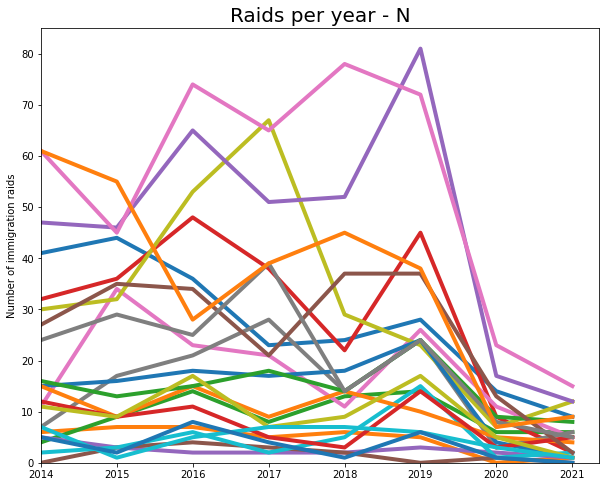

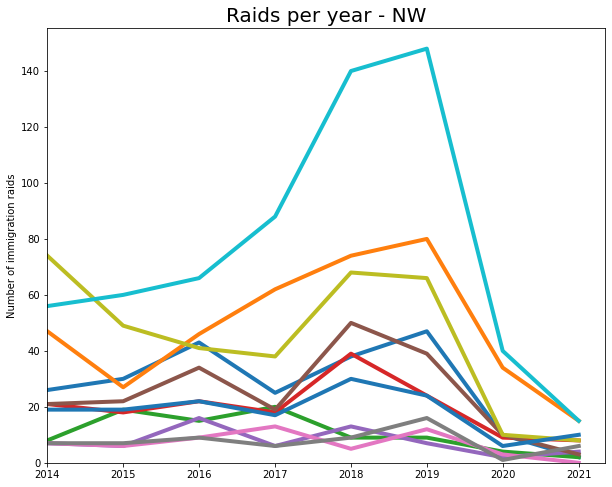

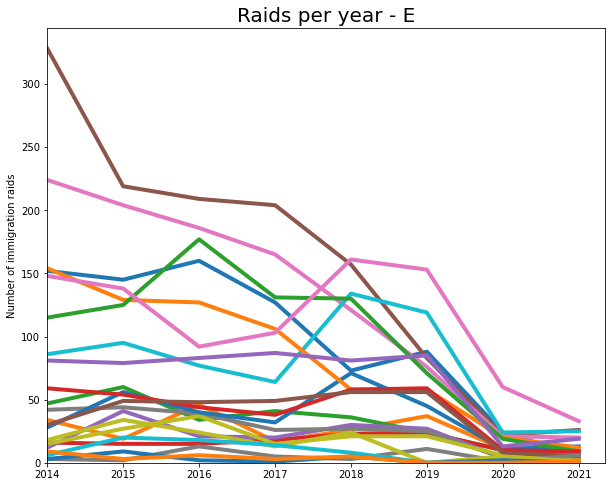

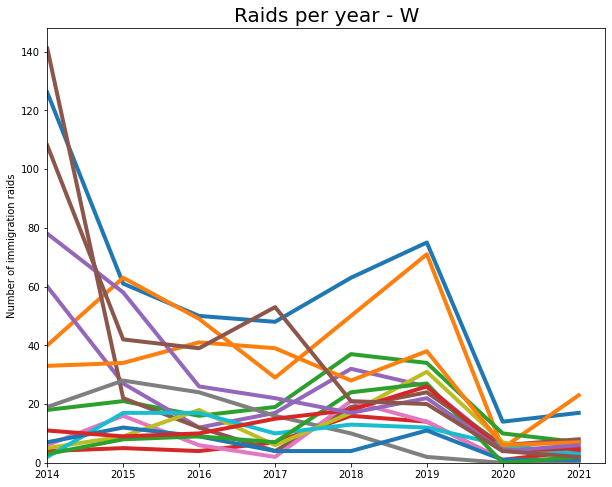

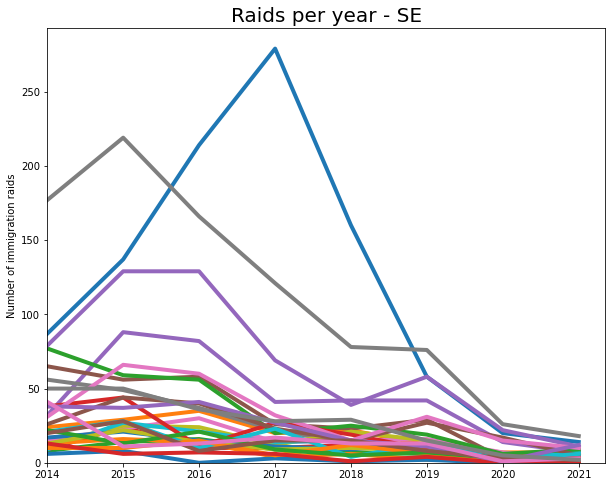

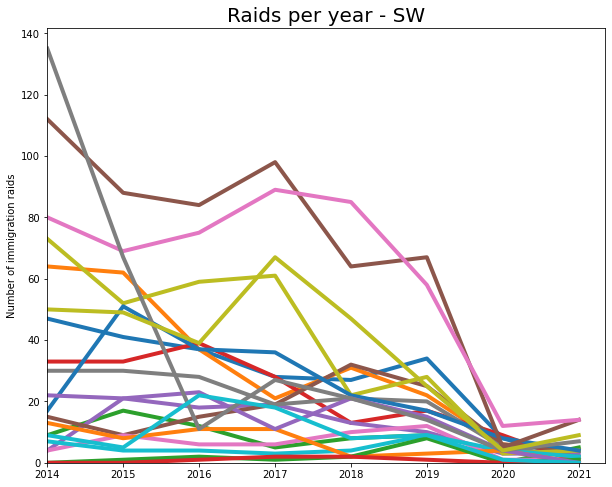

In [12]:
for postarea in ['N', 'NW', 'E', 'W', 'SE', 'SW']:
    df = pd.read_csv('AmendedData\\YearByLondonPostDist_{}.csv'.format(postarea), index_col=0)
    # Merge the central postdists
    central_postdists = list(df.columns[df.columns.str.contains('[A-Z]\d[A-Z]', regex=True)])
    central_postdists_dedupe = sorted(list(set([i[:-1] for i in central_postdists])))
    central_merge = pd.DataFrame(index=df.index, columns=central_postdists_dedupe)
    for postd in central_postdists_dedupe:
        central_merge[postd] = df[[cpd for cpd in central_postdists if postd in cpd]].sum(axis=1)
    df = df.drop(central_postdists, axis=1).join(central_merge)
    # Sort the df into a sensible order
    not_central = sorted([x for x in df.columns if x[1:] in [str(i) for i in range(1, 100)]])
    central = sorted([x for x in df.columns if x[1:] not in [str(i) for i in range(1, 100)]])
    not_central_sorted = sorted(not_central, key=lambda x: float(x[1:]))
    central_sorted = sorted(central, key=lambda x: float(x[2:]))
    sorted_pds = not_central_sorted + central_sorted
    assert len(sorted_pds) == len(df.columns)
    df = df[sorted_pds]
    # Datify the index
    df.index = pd.to_datetime(df.index, format='%Y')
    # plot line + confidence interval
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_ylabel('Number of immigration raids')
    ax.set_title('Raids per year - {}'.format(postarea), size=20)
    for key, val in df.iteritems():
        l, = ax.plot(val.index, val.values, label=key, linewidth=4)
        plugins.connect(fig, plugins.LineLabelTooltip(l, label=key))
    ax.set_ylim(0)
    ax.set_xlim(pd.Timestamp('2014-01-01'))
    # define interactive legend
    handles, labels = ax.get_legend_handles_labels() # return lines and labels
    interactive_legend = plugins.InteractiveLegendPlugin(handles,
                                                         labels,
                                                         alpha_unsel=0.1,
                                                         alpha_over=2.5, 
                                                         start_visible=False)
    plugins.connect(fig, interactive_legend)
    mpld3.save_html(fig, 'Outputs\\InteractiveLine_{}.html'.format(postarea))